<a href="https://colab.research.google.com/github/shreyag212/Gravitation-Waves-Analysis/blob/main/AmplitudeAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries and loading screen function

In [1]:
! pip install -q 'PyCBC==1.18.0' 'lalsuite==6.82'

     |████████████████████████████████| 6.3 MB 6.7 MB/s 
     |████████████████████████████████| 27.3 MB 62.3 MB/s 
     |████████████████████████████████| 75 kB 3.4 MB/s 
     |████████████████████████████████| 51 kB 5.7 MB/s 
     |████████████████████████████████| 201 kB 42.3 MB/s 
     |████████████████████████████████| 1.4 MB 44.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 55 kB 1.5 MB/s 
     |████████████████████████████████| 295 kB 41.2 MB/s 
     |████████████████████████████████| 3.6 MB 45.1 MB/s 


In [2]:
from pycbc.waveform import get_td_waveform
import pylab
from IPython.display import clear_output

import numpy as np
from random import choice
import pandas as pd
import random
import seaborn as sns

In [3]:
def progress(i,ln):
    perc = int(i/ln)
    clear_output(wait = True)
    print('Progress:', round((i/ln)*100), '%')
        
    if i == ln-1:
        clear_output(wait = True)
        #print('Done!')

def blankdf(cols = ['M1', 'M2', 'D', 'Hws', 'lag', 'amp']):
  df = np.arange(int(len(cols)*2))
  df = df.reshape(2,len(cols))
  df = pd.DataFrame(df, columns = cols)
  df.drop([0,1], inplace=True)
  return df

## Function for Making Waveforms

In [4]:

def gwaves(M1=10, M2=5, D=6, N=250, showstrain=False, HL=False, Random = False, showdist=False, Dlog=True, time=200, frate = 1.0/4096):

  ## Params ##
  if isinstance(M1, list) == False:
    M1 = [M1,M1]
  if isinstance(M2, list) == False:
    M2 = [M2,M2]
  if isinstance(D, list) == False:
    D = [D,D]

  if M1[0] < M2[0]: # making sure Primary Mass range > Secondary Mass range 
    M1[0] = M2[0]

  
  if Dlog:
    D = [10**x for x in D]
    print('yes')
  print(D[:10])

  M1 = np.linspace(M1[0],M1[1], N)
  M2 = np.linspace(M2[0],M2[1], N)  
  D = np.linspace(D[0],D[1], N)
  D= D.astype(int)

  if Random:
    M1 = [choice(M1) for _ in range(N)]
    M2 = [choice(M2) for _ in range(N)]  
    D = [choice(D) for _ in range(N)]


  for i in range(N):
    if M1[i] < M2[i]:
      temp = M1[i]
      M1[i] = M2[i]
      M2[i] = temp

  M1 = [round(m,2) for m in M1]
  M2 = [round(m,2) for m in M2]
  # Get Waveform #
  
  times = np.linspace(-100,100,int(time/frate))
  Hf = np.zeros(len(times))

  if showstrain:
    if HL: 
      fig,ax = pylab.subplots(1,3, figsize = (16,4))
    else:
      fig,ax = pylab.subplots(1,2, figsize = (12,4))

  if HL:
    df = blankdf(cols=['M1', 'M2', 'D', 'Hws', 'lag', 'amp'])
    Lv = np.zeros(len(times))
    tlag = np.array([0.8, 0, -0.3])*0.01
  else:
    df = blankdf(cols=['M1', 'M2', 'D', 'Hws', 'amp'])

  for i in range(N):
    progress(i,N)
    print('Primary Mass: ', M1[i], ' M')
    print('Secondary Mass: ', M2[i], ' M')
    print('Luminosity Distance: ', D[i], ' Mpc')
    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                            mass1=M1[i],
                            mass2=M2[i],
                            delta_t=frate,
                            f_lower=20,
                            distance=D[i])
  
    Hws = np.random.randint(0, len(Hf) - len(hp))
    Hf[Hws:Hws+len(hp)] += hp.numpy()
    amp = max(abs(hp.numpy()))

    if HL:
      lag = tlag[random.randint(2)]
      Lws = int(Hws + lag/frate)
      Lv[Lws:Lws+len(hp)] += hp.numpy()
      key = {'M1': M1[i], 'M2': M2[i], 'D': D[i], 'Hws': Hws, 'lag': lag, 'amp': amp}
    else:
      key = {'M1': M1[i], 'M2': M2[i], 'D': D[i], 'Hws': Hws, 'amp': amp}
    
    df = df.append(key, ignore_index=True)

    if showstrain:
      ax[0].plot(hp.sample_times, hp)

  clear_output(wait = True)
  if showstrain:
    ax[0].set_xlabel('Time (s)', fontsize = 18)
    ax[0].set_ylabel('Strain', fontsize = 18)
    ax[0].set_title('Individual Waveforms', fontsize = 18, pad=20)

    ax[1].plot(times, Hf)
    ax[1].set_title('Time Shifted Waveforms (LIGO H)', fontsize = 18, pad=20)
    ax[1].set_xlabel('Time (s)', fontsize = 18)
    ax[1].set_ylabel('Strain', fontsize = 18)

    pylab.setp(ax[0].get_xticklabels(), fontsize=18)
    pylab.setp(ax[0].get_yticklabels(), fontsize=18)
    pylab.setp(ax[1].get_xticklabels(), fontsize=18)
    pylab.setp(ax[1].get_yticklabels(), fontsize=18)

    if HL:
      ax[2].plot(times, Lv)
      ax[2].set_title('Time Shifted Waveforms (LIGO L)', fontsize = 18, pad=20)
      ax[2].set_xlabel('Time (s)', fontsize = 18)
      ax[2].set_ylabel('Strain', fontsize = 18)

      pylab.setp(ax[2].get_xticklabels(), fontsize=18)
      pylab.setp(ax[2].get_yticklabels(), fontsize=18)

    pylab.show()
    

  if showdist:
    fig,ax = pylab.subplots(1,2)
    ax[0].hist(M1, bins = 10,color = 'C1', label ='m1')
    ax[0].hist(M2, bins = 10, alpha = 0.5, color = 'black', label = 'm2')
    ax[0].legend()
    ax[0].set_xlabel('mass (Solar Mases)')
    ax[0].set_ylabel('count')
    ax[0].set_title("Random Distributions of Companent Masses")
    ax[1].set_title("Random Distribution of Distances")
    ax[1].set_xlabel('Distance (Mpc)')
    ax[1].set_ylabel('count')
    ax[1].hist(D, bins = 100)

    pylab.show()
    
  if HL:
    return df, Hf, Lv
  else:
    return df, Hf


# Analysis

### Constant Distance and M2

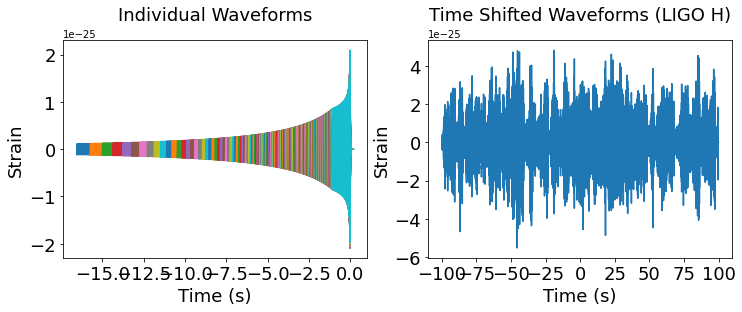

In [6]:
lowM2, _ = gwaves(M1=[6,100], M2 = 5, D = 6, showstrain=True, N=250)

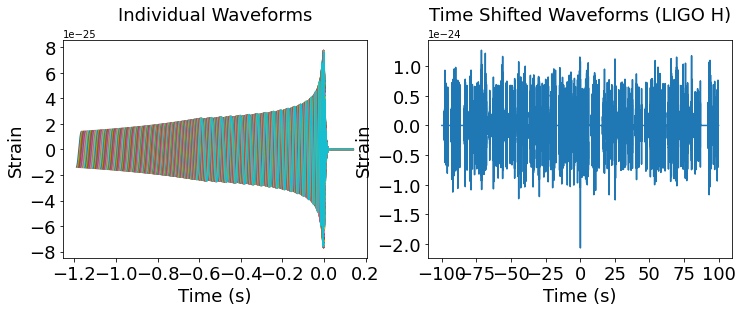

In [11]:
highM2, _ = gwaves(M1=[25,50], M2 = 25, D = 6, showstrain=True, N=250)

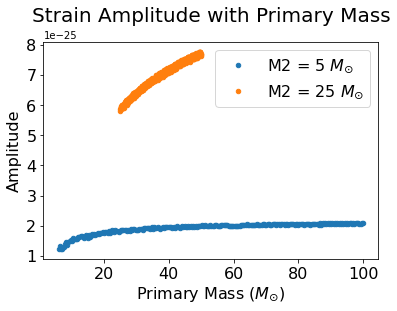

In [8]:
fig,ax = pylab.subplots()
lowM2.plot.scatter(x='M1', y='amp', ax=ax, label = 'M2 = 5 $ M_{\odot}$')
highM2.plot.scatter(x='M1', y='amp', ax=ax, label = 'M2 = 25 $ M_{\odot}$', color='C1')


ax.set_title('Strain Amplitude with Primary Mass', fontsize=20, pad=20)
ax.set_xlabel('Primary Mass ($ M_{\odot}$)', fontsize=16)
ax.set_ylabel('Amplitude', fontsize=16)
ax.legend(fontsize=16)
pylab.setp(ax.get_xticklabels(), fontsize=16)
pylab.setp(ax.get_yticklabels(), fontsize=16)
pylab.show()

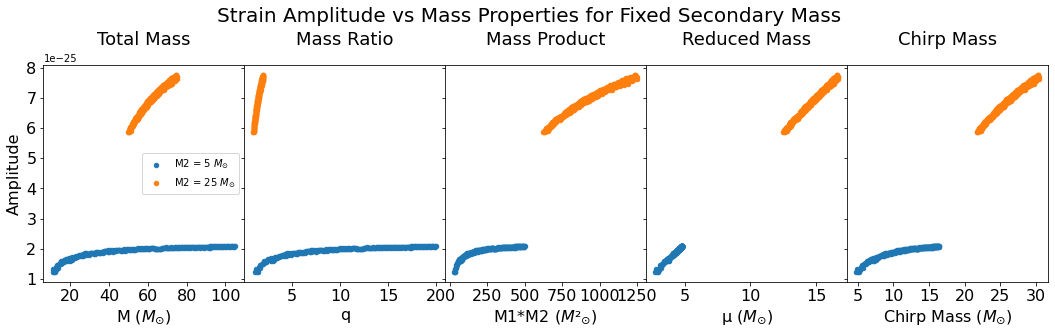

In [12]:
lowM2['M'] = lowM2['M1'] + lowM2['M2']
lowM2['q'] = lowM2['M1'] / lowM2['M2']
lowM2['M Product'] = lowM2['M1'] * lowM2['M2']
lowM2['mu'] = lowM2['M Product']/lowM2['M']
lowM2['Chirp'] = ((lowM2['M Product'])**(3/5)) / (lowM2['M']**(1/5))

highM2['M'] = highM2['M1'] + highM2['M2']
highM2['q'] = highM2['M1'] / highM2['M2']
highM2['M Product'] = highM2['M1'] * highM2['M2']
highM2['mu'] = highM2['M Product']/highM2['M']
highM2['Chirp'] = ((highM2['M Product'])**(3/5)) / (highM2['M']**(1/5))

fig,ax= pylab.subplots(1,5, figsize=(18,4), sharey=True)
lowM2.plot.scatter(x='M', y='amp', ax=ax[0], label = 'M2 = 5 $ M_{\odot}$', color='C0')
lowM2.plot.scatter(x='q', y='amp', ax=ax[1], color='C0')
lowM2.plot.scatter(x='M Product', y='amp', ax=ax[2], color='C0')
lowM2.plot.scatter(x='mu', y='amp', ax=ax[3], color='C0')
lowM2.plot.scatter(x='Chirp', y='amp', ax=ax[4], color='C0')

highM2.plot.scatter(x='M', y='amp', ax=ax[0], label = 'M2 = 25 $ M_{\odot}$', color='C1')
highM2.plot.scatter(x='q', y='amp', ax=ax[1], color='C1')
highM2.plot.scatter(x='M Product', y='amp', ax=ax[2], color='C1')
highM2.plot.scatter(x='mu', y='amp', ax=ax[3], color='C1')
highM2.plot.scatter(x='Chirp', y='amp', ax=ax[4], color='C1')

pylab.suptitle('Strain Amplitude vs Mass Properties for Fixed Secondary Mass', fontsize=20, y=1.08)#, pad=20)
ax[0].set_title('Total Mass', fontsize=18, pad=20)
ax[1].set_title('Mass Ratio', fontsize=18, pad=20)
ax[2].set_title('Mass Product', fontsize=18, pad=20)
ax[3].set_title('Reduced Mass', fontsize=18, pad=20)
ax[4].set_title('Chirp Mass', fontsize=18, pad=20)

ax[0].set_ylabel('Amplitude', fontsize=16)
ax[0].set_xlabel('M ($ M_{\odot}$)', fontsize=16)
ax[1].set_xlabel('q', fontsize=16)
ax[2].set_xlabel('M1*M2 ($ M\u00b2_{\odot}$)', fontsize=16)
ax[3].set_xlabel('\u03BC ($ M_{\odot}$)', fontsize=16)
ax[4].set_xlabel('Chirp Mass ($ M_{\odot}$)', fontsize=16)
fig.subplots_adjust(wspace=0)

pylab.setp(ax[0].get_yticklabels(), fontsize=16)
pylab.setp(ax[0].get_xticklabels(), fontsize=16)
pylab.setp(ax[1].get_xticklabels(), fontsize=16)
pylab.setp(ax[2].get_xticklabels(), fontsize=16)
pylab.setp(ax[3].get_xticklabels(), fontsize=16)
pylab.setp(ax[4].get_xticklabels(), fontsize=16)
pylab.show()

### Constant Distance

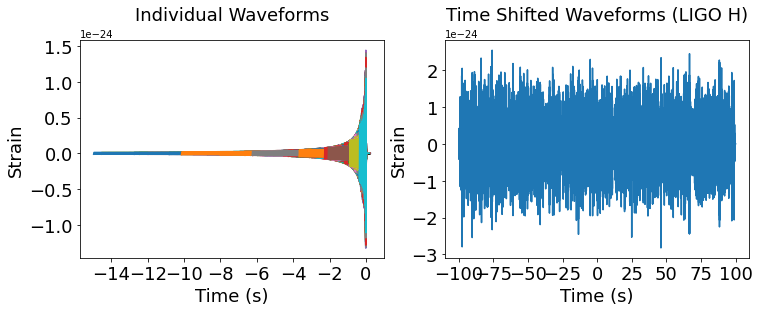

In [10]:
variedM, _ = gwaves(Random=True, M1=[6,80], M2=[5,50], D=6, N=1500, showstrain=True)

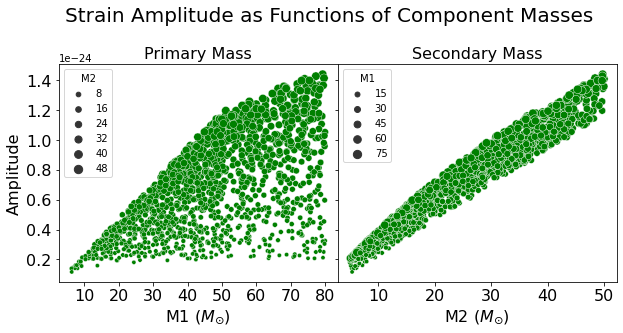

In [13]:
fig,ax= pylab.subplots(1,2, figsize=(10,4), sharey=True)
ax[0].set_title('Primary Mass', fontsize=16)
ax[1].set_title('Secondary Mass', fontsize=16)
pylab.suptitle('Strain Amplitude as Functions of Component Masses', fontsize=20, y=1.08)
pylab.subplots_adjust(wspace=0)
ax[0].set_ylabel('Amplitude', fontsize=16)
ax[0].set_xlabel('M1 ($ M_{\odot}$)', fontsize=16)
ax[1].set_xlabel('M2 ($ M_{\odot}$)', fontsize=16)
pylab.setp(ax[0].get_yticklabels(), fontsize=16)
pylab.setp(ax[0].get_xticklabels(), fontsize=16)
pylab.setp(ax[1].get_xticklabels(), fontsize=16)

sns.scatterplot(data=variedM, x='M1', y='amp', size='M2', ax=ax[0], color='green')
sns.scatterplot(data=variedM, x='M2', y='amp', size='M1', ax=ax[1], color='green')
pylab.show()

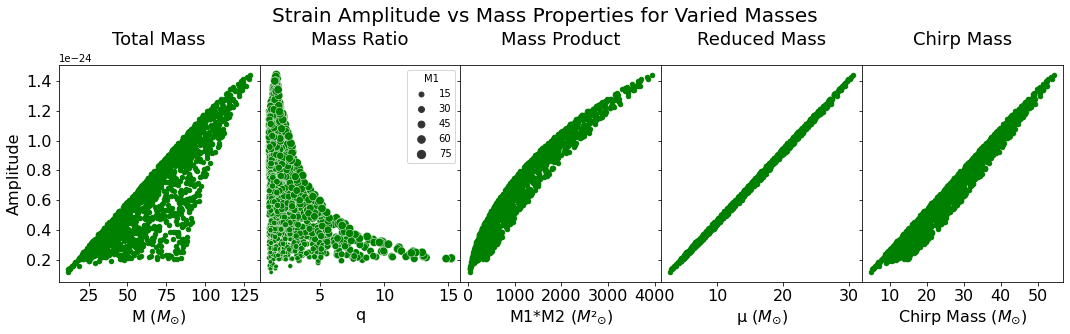

In [14]:
variedM['M'] = variedM['M1'] + variedM['M2']
variedM['q'] = variedM['M1'] / variedM['M2']
variedM['M Product'] = variedM['M1'] * variedM['M2']
variedM['mu'] = variedM['M Product']/variedM['M']
variedM['Chirp'] = ((variedM['M Product'])**(3/5)) / (variedM['M']**(1/5))

fig,ax= pylab.subplots(1,5, figsize=(18,4), sharey=True)
variedM.plot.scatter(x='M', y='amp', ax=ax[0], color='green')
sns.scatterplot(data=variedM, x='q', y='amp', size='M1', ax=ax[1], color='green')
variedM.plot.scatter(x='M Product', y='amp', ax=ax[2], color='green')
variedM.plot.scatter(x='mu', y='amp', ax=ax[3], color='green')
variedM.plot.scatter(x='Chirp', y='amp', ax=ax[4], color='green')

pylab.suptitle('Strain Amplitude vs Mass Properties for Varied Masses', fontsize=20, y=1.08)#, pad=20)
ax[0].set_title('Total Mass', fontsize=18, pad=20)
ax[1].set_title('Mass Ratio', fontsize=18, pad=20)
ax[2].set_title('Mass Product', fontsize=18, pad=20)
ax[3].set_title('Reduced Mass', fontsize=18, pad=20)
ax[4].set_title('Chirp Mass', fontsize=18, pad=20)

ax[0].set_ylabel('Amplitude', fontsize=16)
ax[0].set_xlabel('M ($ M_{\odot}$)', fontsize=16)
ax[1].set_xlabel('q', fontsize=16)
ax[2].set_xlabel('M1*M2 ($ M\u00b2_{\odot}$)', fontsize=16)
ax[3].set_xlabel('\u03BC ($ M_{\odot}$)', fontsize=16)
ax[4].set_xlabel('Chirp Mass ($ M_{\odot}$)', fontsize=16)
fig.subplots_adjust(wspace=0)

pylab.setp(ax[0].get_yticklabels(), fontsize=16)
pylab.setp(ax[0].get_xticklabels(), fontsize=16)
pylab.setp(ax[1].get_xticklabels(), fontsize=16)
pylab.setp(ax[2].get_xticklabels(), fontsize=16)
pylab.setp(ax[3].get_xticklabels(), fontsize=16)
pylab.setp(ax[4].get_xticklabels(), fontsize=16)
pylab.show()

## Comparing Strain Amplitudes for Waveforms With and Without Fixed Secondary Mass

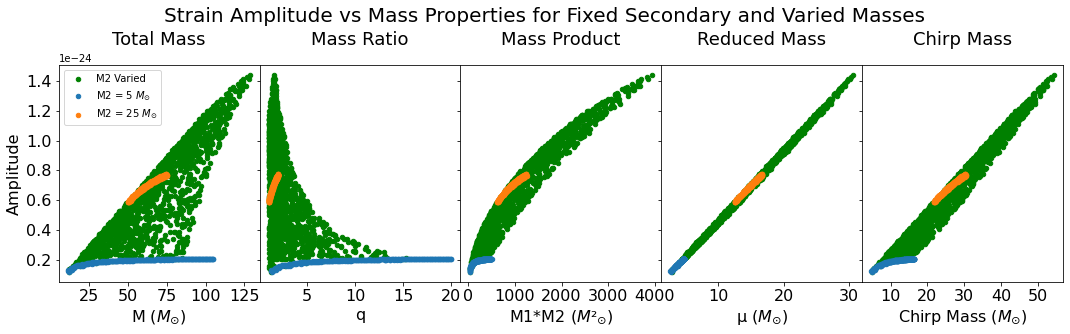

In [15]:
fig,ax= pylab.subplots(1,5, figsize=(18,4), sharey=True)

variedM.plot.scatter(x='M', y='amp', ax=ax[0], color='green', label = 'M2 Varied')
variedM.plot.scatter(x='q', y='amp', ax=ax[1], color='green')
variedM.plot.scatter(x='M Product', y='amp', ax=ax[2], color='green')
variedM.plot.scatter(x='mu', y='amp', ax=ax[3], color='green')
variedM.plot.scatter(x='Chirp', y='amp', ax=ax[4], color='green')

lowM2.plot.scatter(x='M', y='amp', ax=ax[0], label = 'M2 = 5 $ M_{\odot}$', color='C0')
lowM2.plot.scatter(x='q', y='amp', ax=ax[1], color='C0')
lowM2.plot.scatter(x='M Product', y='amp', ax=ax[2], color='C0')
lowM2.plot.scatter(x='mu', y='amp', ax=ax[3], color='C0')
lowM2.plot.scatter(x='Chirp', y='amp', ax=ax[4], color='C0')

highM2.plot.scatter(x='M', y='amp', ax=ax[0], label = 'M2 = 25 $ M_{\odot}$', color='C1')
highM2.plot.scatter(x='q', y='amp', ax=ax[1], color='C1')
highM2.plot.scatter(x='M Product', y='amp', ax=ax[2], color='C1')
highM2.plot.scatter(x='mu', y='amp', ax=ax[3], color='C1')
highM2.plot.scatter(x='Chirp', y='amp', ax=ax[4], color='C1')

pylab.suptitle('Strain Amplitude vs Mass Properties for Fixed Secondary and Varied Masses', fontsize=20, y=1.08)#, pad=20)
ax[0].set_title('Total Mass', fontsize=18, pad=20)
ax[1].set_title('Mass Ratio', fontsize=18, pad=20)
ax[2].set_title('Mass Product', fontsize=18, pad=20)
ax[3].set_title('Reduced Mass', fontsize=18, pad=20)
ax[4].set_title('Chirp Mass', fontsize=18, pad=20)

ax[0].set_ylabel('Amplitude', fontsize=16)
ax[0].set_xlabel('M ($ M_{\odot}$)', fontsize=16)
ax[1].set_xlabel('q', fontsize=16)
ax[2].set_xlabel('M1*M2 ($ M\u00b2_{\odot}$)', fontsize=16)
ax[3].set_xlabel('\u03BC ($ M_{\odot}$)', fontsize=16)
ax[4].set_xlabel('Chirp Mass ($ M_{\odot}$)', fontsize=16)
fig.subplots_adjust(wspace=0)

pylab.setp(ax[0].get_yticklabels(), fontsize=16)
pylab.setp(ax[0].get_xticklabels(), fontsize=16)
pylab.setp(ax[1].get_xticklabels(), fontsize=16)
pylab.setp(ax[2].get_xticklabels(), fontsize=16)
pylab.setp(ax[3].get_xticklabels(), fontsize=16)
pylab.setp(ax[4].get_xticklabels(), fontsize=16)
pylab.show()

### Fixed M1

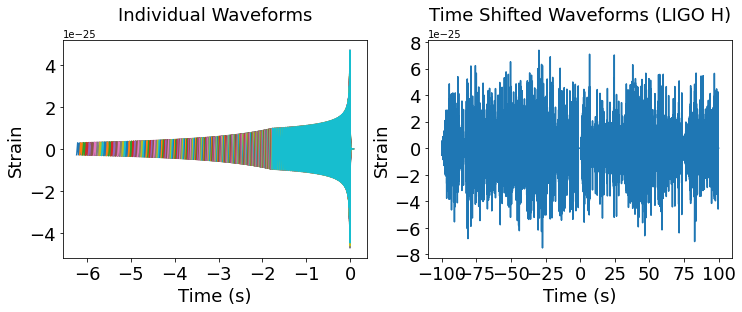

In [16]:
lowM1, _ = gwaves(M1=20, M2=[5,20], D=6, N=250, showstrain=True)

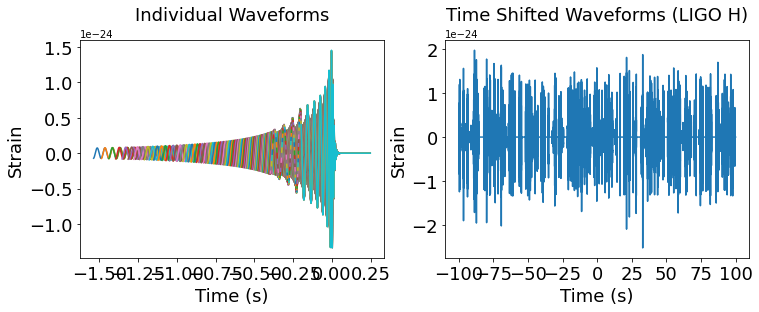

In [17]:
highM1, _ = gwaves(M1=80, M2=[5,50], D=6, N=250, showstrain=True)

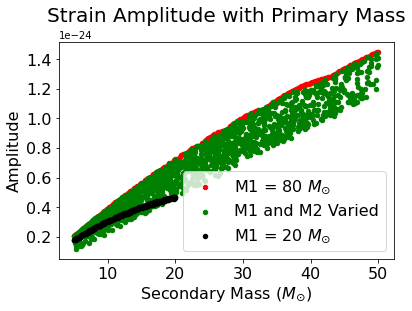

In [18]:
fig,ax = pylab.subplots()

highM1.plot.scatter(x='M2', y='amp', ax=ax, label = 'M1 = 80 $ M_{\odot}$', color='red')
variedM.plot.scatter(x='M2', y='amp', ax=ax, label = 'M1 and M2 Varied', color='green')
lowM1.plot.scatter(x='M2', y='amp', ax=ax, label = 'M1 = 20 $ M_{\odot}$', color='black')
ax.set_title('Strain Amplitude with Primary Mass', fontsize=20, pad=20)
ax.set_xlabel('Secondary Mass ($ M_{\odot}$)', fontsize=16)
ax.set_ylabel('Amplitude', fontsize=16)
ax.legend(fontsize=16)

pylab.setp(ax.get_xticklabels(), fontsize=16)
pylab.setp(ax.get_yticklabels(), fontsize=16)
pylab.show()

In [19]:
highM1['M'] = highM1['M1'] + highM1['M2']
highM1['q'] = highM1['M1'] / highM1['M2']
highM1['M Product'] = highM1['M1'] * highM1['M2']
highM1['mu'] = highM1['M Product']/highM1['M']
highM1['Chirp'] = ((highM1['M Product'])**(3/5)) / (highM1['M']**(1/5))

lowM1['M'] = lowM1['M1'] + lowM1['M2']
lowM1['q'] = lowM1['M1'] / lowM1['M2']
lowM1['M Product'] = lowM1['M1'] * lowM1['M2']
lowM1['mu'] = lowM1['M Product']/lowM1['M']
lowM1['Chirp'] = ((lowM1['M Product'])**(3/5)) / (lowM1['M']**(1/5))

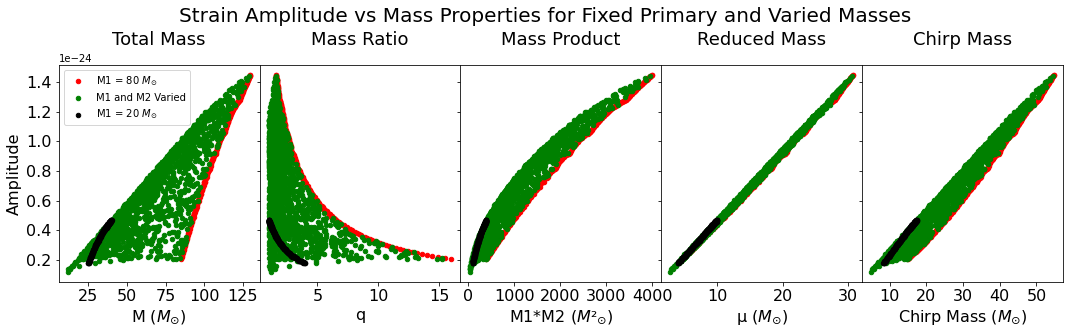

In [20]:
fig,ax= pylab.subplots(1,5, figsize=(18,4), sharey=True)

highM1.plot.scatter(x='M', y='amp', ax=ax[0], color='red', label = 'M1 = 80 $ M_{\odot}$')
highM1.plot.scatter(x='q', y='amp', ax=ax[1], color='red')
highM1.plot.scatter(x='M Product', y='amp', ax=ax[2], color='red')
highM1.plot.scatter(x='mu', y='amp', ax=ax[3], color='red')
highM1.plot.scatter(x='Chirp', y='amp', ax=ax[4], color='red')

variedM.plot.scatter(x='M', y='amp', ax=ax[0], color='green', label = 'M1 and M2 Varied')
variedM.plot.scatter(x='q', y='amp', ax=ax[1], color='green')
variedM.plot.scatter(x='M Product', y='amp', ax=ax[2], color='green')
variedM.plot.scatter(x='mu', y='amp', ax=ax[3], color='green')
variedM.plot.scatter(x='Chirp', y='amp', ax=ax[4], color='green')

lowM1.plot.scatter(x='M', y='amp', ax=ax[0], color='k', label = 'M1 = 20 $ M_{\odot}$')
lowM1.plot.scatter(x='q', y='amp', ax=ax[1], color='k')
lowM1.plot.scatter(x='M Product', y='amp', ax=ax[2], color='k')
lowM1.plot.scatter(x='mu', y='amp', ax=ax[3], color='k')
lowM1.plot.scatter(x='Chirp', y='amp', ax=ax[4], color='k')

pylab.suptitle('Strain Amplitude vs Mass Properties for Fixed Primary and Varied Masses', fontsize=20, y=1.08)#, pad=20)
ax[0].set_title('Total Mass', fontsize=18, pad=20)
ax[1].set_title('Mass Ratio', fontsize=18, pad=20)
ax[2].set_title('Mass Product', fontsize=18, pad=20)
ax[3].set_title('Reduced Mass', fontsize=18, pad=20)
ax[4].set_title('Chirp Mass', fontsize=18, pad=20)

ax[0].set_ylabel('Amplitude', fontsize=16)
ax[0].set_xlabel('M ($ M_{\odot}$)', fontsize=16)
ax[1].set_xlabel('q', fontsize=16)
ax[2].set_xlabel('M1*M2 ($ M\u00b2_{\odot}$)', fontsize=16)
ax[3].set_xlabel('\u03BC ($ M_{\odot}$)', fontsize=16)
ax[4].set_xlabel('Chirp Mass ($ M_{\odot}$)', fontsize=16)
fig.subplots_adjust(wspace=0)

pylab.setp(ax[0].get_yticklabels(), fontsize=16)
pylab.setp(ax[0].get_xticklabels(), fontsize=16)
pylab.setp(ax[1].get_xticklabels(), fontsize=16)
pylab.setp(ax[2].get_xticklabels(), fontsize=16)
pylab.setp(ax[3].get_xticklabels(), fontsize=16)
pylab.setp(ax[4].get_xticklabels(), fontsize=16)
pylab.show()

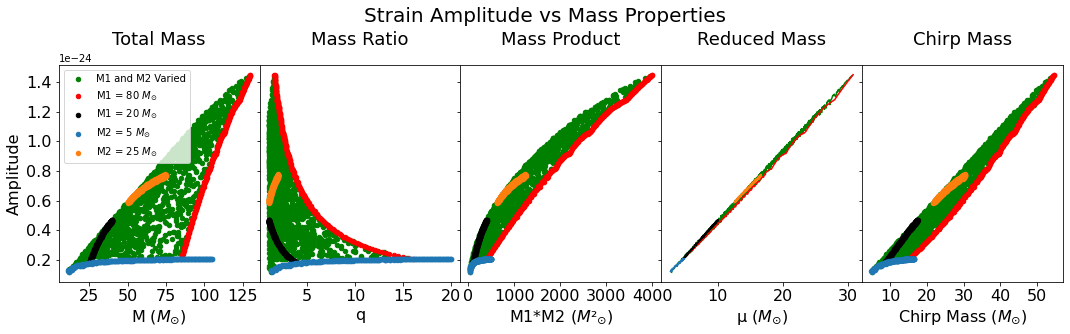

In [21]:
fig,ax= pylab.subplots(1,5, figsize=(18,4), sharey=True)


variedM.plot.scatter(x='M', y='amp', ax=ax[0], color='green', label = 'M1 and M2 Varied')
variedM.plot.scatter(x='q', y='amp', ax=ax[1], color='green')
variedM.plot.scatter(x='M Product', y='amp', ax=ax[2], color='green')
variedM.sort_values('mu').plot(x='mu', y='amp', ax=ax[3], color='green', legend=False)
variedM.plot.scatter(x='Chirp', y='amp', ax=ax[4], color='green')

highM1.plot.scatter(x='M', y='amp', ax=ax[0], color='red', label = 'M1 = 80 $ M_{\odot}$')
highM1.plot.scatter(x='q', y='amp', ax=ax[1], color='red')
highM1.plot.scatter(x='M Product', y='amp', ax=ax[2], color='red')
highM1.plot(x='mu', y='amp', ax=ax[3], color='red', legend=False)
highM1.plot.scatter(x='Chirp', y='amp', ax=ax[4], color='red')

lowM1.plot.scatter(x='M', y='amp', ax=ax[0], color='k', label = 'M1 = 20 $ M_{\odot}$')
lowM1.plot.scatter(x='q', y='amp', ax=ax[1], color='k')
lowM1.plot.scatter(x='M Product', y='amp', ax=ax[2], color='k')
lowM1.plot(x='mu', y='amp', ax=ax[3], color='k', legend=False)
lowM1.plot.scatter(x='Chirp', y='amp', ax=ax[4], color='k')

lowM2.plot.scatter(x='M', y='amp', ax=ax[0], label = 'M2 = 5 $ M_{\odot}$', color='C0')
lowM2.plot.scatter(x='q', y='amp', ax=ax[1], color='C0')
lowM2.plot.scatter(x='M Product', y='amp', ax=ax[2], color='C0')
lowM2.plot(x='mu', y='amp', ax=ax[3], color='C0', legend=False)
lowM2.plot.scatter(x='Chirp', y='amp', ax=ax[4], color='C0')

highM2.plot.scatter(x='M', y='amp', ax=ax[0], label = 'M2 = 25 $ M_{\odot}$', color='C1')
highM2.plot.scatter(x='q', y='amp', ax=ax[1], color='C1')
highM2.plot.scatter(x='M Product', y='amp', ax=ax[2], color='C1')
highM2.plot(x='mu', y='amp', ax=ax[3], color='C1', legend=False)
highM2.plot.scatter(x='Chirp', y='amp', ax=ax[4], color='C1')

pylab.suptitle('Strain Amplitude vs Mass Properties', fontsize=20, y=1.08)#, pad=20)
ax[0].set_title('Total Mass', fontsize=18, pad=20)
ax[1].set_title('Mass Ratio', fontsize=18, pad=20)
ax[2].set_title('Mass Product', fontsize=18, pad=20)
ax[3].set_title('Reduced Mass', fontsize=18, pad=20)
ax[4].set_title('Chirp Mass', fontsize=18, pad=20)

ax[0].set_ylabel('Amplitude', fontsize=16)
ax[0].set_xlabel('M ($ M_{\odot}$)', fontsize=16)
ax[1].set_xlabel('q', fontsize=16)
ax[2].set_xlabel('M1*M2 ($ M\u00b2_{\odot}$)', fontsize=16)
ax[3].set_xlabel('\u03BC ($ M_{\odot}$)', fontsize=16)
ax[4].set_xlabel('Chirp Mass ($ M_{\odot}$)', fontsize=16)
fig.subplots_adjust(wspace=0)

pylab.setp(ax[0].get_yticklabels(), fontsize=16)
pylab.setp(ax[0].get_xticklabels(), fontsize=16)
pylab.setp(ax[1].get_xticklabels(), fontsize=16)
pylab.setp(ax[2].get_xticklabels(), fontsize=16)
pylab.setp(ax[3].get_xticklabels(), fontsize=16)
pylab.setp(ax[4].get_xticklabels(), fontsize=16)
pylab.show()

## Fitting Amplitude vs $\mu$

In [22]:
jointdf = pd.concat([lowM2,highM2,lowM1,highM1,variedM], ignore_index=True)

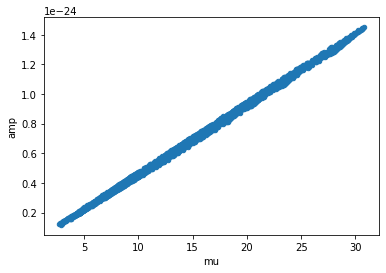

In [24]:
jointdf = jointdf.sort_values('amp')
jointdf.plot.scatter(x='mu', y='amp', legend=False)

In [25]:
xdata = jointdf['mu'].values.tolist()
ydata = jointdf['amp'].values.tolist()

In [26]:
from scipy.optimize import curve_fit

def func(x,m,c):
  return m * x + c

In [27]:
popt, pcov = curve_fit(func, xdata, ydata)
print(popt)
print(np.sqrt(pcov[0][0]))
print(np.sqrt(pcov[1][1]))

[ 4.72456161e-26 -1.38262601e-26]
3.065874210553667e-29
4.620193996304932e-28


4.724561610324437e-26 -1.382626008349472e-26
3.065874210553667e-29 4.620193996304932e-28


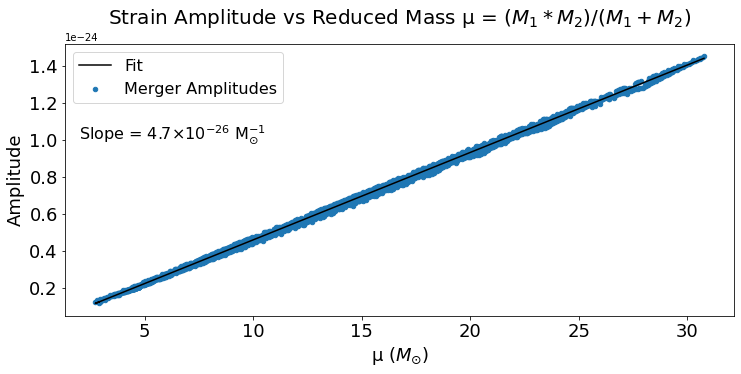

In [83]:
yfit = np.array(xdata)*popt[0] + popt[1]
fig,ax = pylab.subplots(figsize= (12,5))

y1 = np.array(xdata)*(popt[0] - np.sqrt(pcov[0][0])) + (popt[1] - np.sqrt(pcov[1][1]))
y2 = np.array(xdata)*(popt[0] + np.sqrt(pcov[0][0])) + (popt[1] + np.sqrt(pcov[1][1]))

jointdf.plot.scatter(x='mu', y='amp', ax=ax, label = 'Merger Amplitudes')
ax.plot(xdata,yfit,color='k', label='Fit')
print(popt[0],popt[1])
print(np.sqrt(pcov[0][0]),np.sqrt(pcov[1][1]))

ax.set_title('Strain Amplitude vs Reduced Mass \u03BC = ($M_1 * M_2)/(M_1 + M_2)$', fontsize=20, pad=20)
ax.set_xlabel('\u03BC ($ M_{\odot}$)', fontsize=18)
ax.set_ylabel('Amplitude', fontsize=18)
ax.legend(fontsize=16)
pylab.setp(ax.get_xticklabels(), fontsize=18)
pylab.setp(ax.get_yticklabels(), fontsize=18)
ax.text(2,10**(-24), r'Slope = 4.7$ \times\mathregular{10^{-26}}$ $\mathregular{M_{\odot}^{-1}}$ ', fontsize = 16)
pylab.show()


In [ ]:
perr = np.sqrt(np.diag(pcov))
perr

array([2.56845208e-29, 3.77879489e-28])